# Examples

This notebook contains many examples intended to demonstrate the power of [Stimsym](https://github.com/c-cube/stimsym).

 ## The Basics

Stimsym is a symbolic language, where we manipulate expressions, not simply values. `a+b` is just an expression that evaluates to itself, since we do not know a concrete value for `a` or for `b`. Similarly, `f[a,b]` is the application of the function `f` to arguments `a,b`. Since `f` is not defined, the application does not evaluate, and it’s fine!

In [1]:
1 + 2

3


In [2]:
1 + a + 2

3+a


In [3]:
f[a,b,c]

f[a,b,c]


In [4]:
f[a,1+2+c]

f[a,3+c]


We can define (partially) a function using `:=`.
There is no static typing, and no need to defined a function on all its
possible arguments:

In [5]:
f[x_,0] := x

In [6]:
FullForm[Hold[f[x_,0] := x]]

Hold[AssignDelayed[f[Pattern[x,Blank[]],0],x]]


In [7]:
f[a, 0]

a


In [8]:
f[b]  (* no rule matches *)

f[b]


In [9]:
f[a, 42]

f[a,42]


In [10]:
f[a,0+0]

a


In this definition, you might have noticed how `x` appears with
the `_` on the left, but not on the right.
`x_` is actually a **blank pattern**: it matches any expression (any cargument)
and binds the argument to the variable `x`.
So, `g[x_,y_] := 2 x + y` defines `g` as a function that takes any two
expressions and sums them after doubling the first one: `g[10,3]` will be `23`.
More complicated **patterns** will only match some expressions.

**Expressions** are built from the following ingredients:

- integers: `1`, `-2`, `1234542452626246246225114787` (arbitrary precision)
- rationals: `1/2`, `-5/10`, etc.
- strings: `"ab cd"`, `"f[a]"`, `"1+1"`
- symbols: any string composed of alphanumeric objects
- builtins: many builtin functions, such as `Plus`. They often have
  a shortcut representation, e.g. `Plus[a,b,c]` is `a+b+c+`, `Times[a,2]` is `a 2`, etc.
- applications: `expr[expr,expr,…]` applies the first expression to
  a sequence of arguments.
  
  * `f[]` applies `f` to 0 arguments;
  * `f[a]` applies `f` to `a`;
  * `f[a][b,c]` applies `f[a]` to arguments `b, c`.

The primary container is the **list**, denoted `List[a,b,c]` or `{a,b,c}`.
However, it is possible to store elements under any symbol that is
not defined:

In [11]:
{{a},{b,1+1}}

{{a},{b,2}}


In [12]:
SomeSymbol[a,b,c]

SomeSymbol[a,b,c]


## Rewriting

The primary operation for evaluating expressions is **rewriting**.
Every definition (`pattern := expr`) defines a rule that rewrites
anything matching the pattern, to the expression.

Some expressions define "local" rewriting rules:

- `pattern -> expr` evaluates `expr` first, then defines the rule
  mapping anything matching `pattern` to the evaluated expression.
  This is typically only useful if `pattern` binds no variables (e.g.
  if `pattern` is a constant)
- `pattern :> expr` maps anything matching `pattern` to `expr`.
  Here, `expr` is only evaluated once the pattern matches.
  For instance, `f[x_] :> x+2` will rewrite `f[1]` to `3`,
  `f[98]` to `100`, etc.

The following operators rewrite expressions using local rules:

- `expr //. rules`
  (where `rules` is either one rule, or a list of rules)
  rewrite `expr` with the rules until no rule applies anymore.
- `expr /. rules`
  (where `rules` is either one rule, or a list of rules)
  rewrite `expr` with the rules, but each sub-expression is rewritten
  at most once

In [13]:
g[f[f[f[a]]]] //.  {f[x_]:> x, g[x_] :> h[x]}

h[a]


In [14]:
f[a,b,c] //. { a -> 1, b -> 2, c -> 3 }

f[1,2,3]


In [15]:
f[f[f[a]]] //.  {f[x_]:> g[x], g[x_] :> h[x]}

h[h[h[a]]]


In [16]:
f[f[f[a]]] /.  {f[x_]:> g[x], g[x_] :> h[x]}

g[g[g[a]]]


## Patterns

- blank pattern:
 `_` matches anything.  `x_` matches anything and binds `x` to it.
- blank non empty sequence:
 `__` matches any non-empty **sequence** of arguments:
  `f[a, y__] := {y}` will trigger on any expression `f[a,…]` and match `y` with
  the `…`.

In [17]:
f[a,y__] := {y}

In [18]:
f[a,b,c,d]

{b,c,d}


In [19]:
f[a]  (* does not match *)

f[a]


In [20]:
f[b,c,d]

f[b,c,d]


- blank sequence:
 `__` matches any **sequence** of arguments, including an empty one:
 `f[a, y___] := {y}` is very similar to `f[a,y__] := {y}`
  but will also reduce `f[a]` to `{}`.

- test pattern:
  `p?f` is a pattern that matches any expression `e` against `p`, but
  only if `f[e]` reduces to `True`.
  Typically, `_?IntegerQ` matches any integer, `_?RationalQ`
  any rational (or integer).

- conditional pattern:
  A pattern `p /; expr` matches the same expressions as `p` (where `p`
  is a pattern), but only if `expr` evaluates to `True`.
  The test `expr` is expected to reduce to `True` or `False`;
  otherwise the evaluation fails.
  This is more powerful, but more verbose, than a test pattern:
  `_?IntegerQ` can be expressed as `x_ /; IntegerQ[x]`.

More advanced example involving both a test and a conditional
(because the condition `a+2==3` does not reduce to a boolean,
we guard `x_` with an `IntegerQ` test):

In [21]:
{1,2,a,4} /. (x_?IntegerQ /; (x+2 == 3) :> success[x])

{success[1],2,a,4}


A funny example of rewriting is the following bubble sort (not efficient,
but compact).
It repeatedly rewrites the list `l` using the rule
`{x___,y_,z_,k___}/;(y>z) :> {x,z,y,k}`, which finds two elements `y`
and `z` in a list, with `y>z`, and swaps them.
Note how `x___` and `k___` capture the other elements of the list.

In [22]:
sort[l_] := l //. {x___,y_,z_,k___}/;(y>z) :> {x,z,y,k}

In [23]:
sort[{64,44,71,48,96,47,59,71,73,51,67,50,26,49,49}]

{26,44,47,48,49,49,50,51,59,64,67,71,71,73,96}


Now let's clear `f` for the remaining examples. This removes all rules
that have `f` as the head symbol — in our case, the rule `f[a,y__] := y`.

In [24]:
Clear[f]

## Some Primitives

Stimsym provides many primitives that are predefined for performance or convenience.

In [25]:
a===a  (* syntactic equality *)

True


In [26]:
a===b

False


In [27]:
10>5==5<=7 (* chain of tests *)

True


In [28]:
a==a (* does not reduce *)

a==a


In [29]:
a==a<b

a==a<b


In [30]:
(* rewrite, then evaluate *)
a==a<b /. {a->5,b->10}

True


In [31]:
2^10

1024


In [32]:
6! (* factorial *)

720


Boolean expressions, including:

- conjunction `a && b`
- disjunction `a || b`
- prefix negation `!a`

In [33]:
a&&b || !c

a&&b||!c


- `Hold` blocks evaluation of its arguments
- `FullForm` prints the raw expression, with no syntactic sugar. very convenient for understanding
  some quirks of the parser.

In [34]:
FullForm[Hold[a&&b || !c]]

Hold[Or[And[a,b],Not[c]]]


In [35]:
Hold[1+1]

Hold[1+1]


In [36]:
Nest[f,a,10]

f[f[f[f[f[f[f[f[f[f[a]]]]]]]]]]


In [37]:
(f^10)[a]  (* short for Nest *)

f[f[f[f[f[f[f[f[f[f[a]]]]]]]]]]


## Sequence

The special symbol `Sequence` has the special property that
it "flattens" when it appears in a list of arguments (or a list):

In [38]:
Sequence[a,b]

Sequence[a,b]


In [39]:
f[a,Sequence[b,c],d]

f[a,b,c,d]


In [40]:
{Sequence[1,2],Sequence[3,4],5}

{1,2,3,4,5}


## Comprehensions

Stimsym emphasizes functional programming and pure expressions.
Instead of loops, it provides a powerful **comprehension** mechanism.
A comprehension expression has the form `expr ::cond1, cond2, …`,
a bit similar to python's `expr for … if …` construct.
Conditions are evaluated left-to-right, and have one of the forms:

- `pattern <- expr`, will match `pattern` against `expr`
  and bind variables of `pattern` in the remaining (right-side) conditions

- `pattern <<- expr`, will match `pattern` against every expressions
  immediately beneath `expr`,
  and bind variables of `pattern` in the remaining (right-side) conditions.

  For example, `f[x_] <<- {1,f[2],3,f[4]}` will match `f[x_]` with
  each element of the list in a backtracking fashion.
  First, it will try to match against `1`, fail, then `f[2]`, succeed in
  binding `x_ <- 2`, _evaluate the remaining conditions_,
  then backtrack, fail against 3, succeed against `f[4]`,
  evaluate the remaining conditions with `x_ <- 4`, and terminate.

- `expr`, where the expression will be evaluated with the current bindings,
  and evaluation continues only if `expr` reduces to `True`.
  This is used to add tests, a bit like `bar` in
  python's `expr for x in foo if bar`.

Note that matching a pattern against an expression can return several results.
For instance, `x_+y_ <- a+b` will yield `x=a,y=b` and `x=b,y=a`.
In a comprehension, both choices will be considered and returned,
like clauses in Prolog.

The following expression computes the cartesian product of two lists:

In [41]:
Product[l1_,l2_] := {{x,y} :: x_<<- l1, y_ <<- l2}

In [42]:
Product[{1,2,3},{a,b,c}]

{{1,a},{1,b},{1,c},{2,a},{2,b},{2,c},{3,a},{3,b},{3,c}}


In [43]:
(* alternative way, more convoluted but without <<- *)

Product2[_[l1___], _[l2___]] :=
  {{x,y} ::
   Sequence[___,x_,___] <- l1,
   Sequence[___,y_,___] <- l2}

In [44]:
Product2[{1,2,3},{a,b,c}]

{{1,a},{1,b},{1,c},{2,a},{2,b},{2,c},{3,a},{3,b},{3,c}}


Note that it works for any head symbol, not just lists:

In [45]:
Product2[f1[1,2,3], f2[a,b,c]]

{{1,a},{1,b},{1,c},{2,a},{2,b},{2,c},{3,a},{3,b},{3,c}}


A comprehension returns a `Sequence`, so it flattens under any
other symbol (such as `{}`).

## Let-binding

Very similar to the comprehension, `Let` is an interesting variation.
Its full form is `Let[cond1,…,condn, expr]` where the conditions are
similar to those in comprehensions, but it only returns the first
successful `expr` and discards the other choices.
If there is no successful answer (corresponding to an empty comprehension)
then evaluation fails.

In [46]:
Let[x_<-1, y_<-2, 2 x+y]

4


In [47]:
Let[x_+y_ <- a+b, f[x,y]]

f[a,b]


In [48]:
{f[x,y]:: x_+y_ <-a+b} (* contrast with that *)

{f[a,b],f[b,a]}


In [49]:
Let[x_?IntegerQ <- a, x] (* no answer -> failure! *)

error: evaluation failed: no match for `Let`


In [50]:
Let[x_?IntegerQ <<- {a,b,1,c}, x] (* backtrack until it works *)

1


## Anonymous functions

There is a way to denote simple anonymous functions using the postfix `&`
operator and `#1`, `#2`, … for arguments. `#0` is the whole sequence
of elements.

In [51]:
(#1 &)[a,b,c]

a


In [52]:
(f[#1,{#0}]&)[a,b,c]

f[a,{a,b,c}]


In [53]:
({f[x]:: x_ <<- #0}&)[a,b,c,d]

{f[a],f[b],f[c],f[d]}


In [54]:
(Plus[#0]!&)[1,2,3]  (* sum, then factorial *)

720


In [55]:
Trace[(Plus[#0]!&)[1,2,3]]

720


trace `(#0)!&[1,2,3]` -> `(1+2+3)!` `1+2+3` -> `6` `6!` -> `720`

## Inline Documentation: `Doc`

Evaluating `Doc[f]` where `f` is a builtin symbol will display the
corresponding documentation:

In [56]:
Doc[Plus]

Plus Addition operator. Associative, Commutative, with regular evaluation on numbers. neutral element 0 infix form `a + b + c + d`

## Graph Display

The `Graph` primitive is used to represent graph structures.

In [57]:
Doc[Graph]

Graph A directed graph structure. `Graph[{a->b,…}]` builds a graph from a list of edges. `Graph[Set[a->b,…]]` builds a graph from a set of edges. `Graph[{a,b,c},{a->b,…}]` builds a graph from a list of vertices and a list of edges. The graph has a graphical display in the notebook. example a simple 2-layers graph Graph[{i->j :: i_<<- {1,2,3,4}, j_<<-{a,b,c,d}}]

Here, a simple graph where each node is connected to its two immediate successors in $\mathbb{Z}/6\mathbb{Z}$

Graph[{3,5,2,4,1,0},
      {0->1,0->2,1->2,1->3,2->3,2->4,3->4,3->5,4->5,4->0,5->0,5->1}]


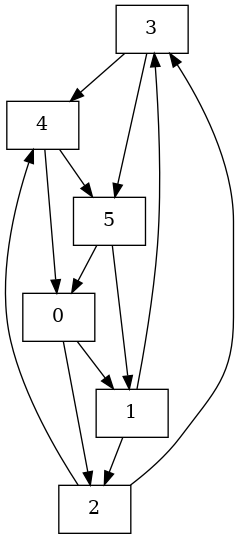

In [58]:
g = Graph[{Sequence[i->Mod[i+1,6],i->Mod[i+2,6]] :: i_<<- Range[5]}]

We can add to the graph edges connecting any vertices that were at distance 2:

In [59]:
graphClosure2[Graph[_, {edges___}]] :=
    Graph[Set[
        edges,
        Sequence[
            (a->c) ::
            (a_->b_) <<- edges,
            ((b2_ /; b2===b)->c_) <<- edges]
    ]]

Graph[{3,5,2,4,1,0},
      {0->1,
       0->2,
       0->3,
       0->4,
       1->2,
       1->3,
       1->4,
       1->5,
       2->0,
       2->3,
       2->4,
       2->5,
       3->0,
       3->1,
       3->4,
       3->5,
       4->0,
       4->1,
       4->2,
       4->5,
       5->0,
       5->1,
       5->2,
       5->3}]


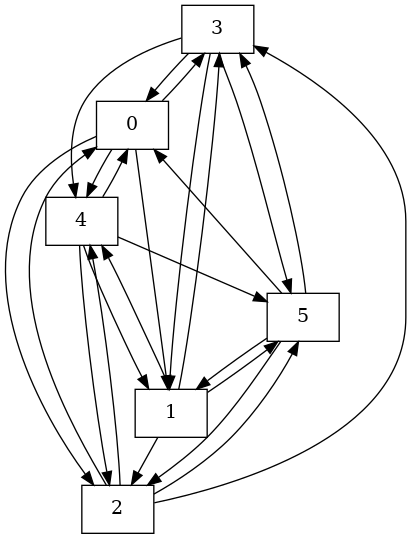

In [60]:
graphClosure2[g]

## Larger Examples

- enumerate the way to split a sum in one atom + 2 sub-sums:
  To do so, we match `a+b+c+d` with the pattern `x_+y__+z__`,
  where `y` and `z` match non-empty sequences.
  Using the comprehension mechanism, we build a term
  `f[x,{y},{z}]` for each result of this matching, and wrap
  the result in a list.

In [61]:
{f[x,{y},{z}] :: x_+y__+z__<-a+b+c+d}

{f[a,{c,b},{d}],
 f[a,{d,b},{c}],
 f[a,{b},{d,c}],
 f[a,{d,c},{b}],
 f[a,{c},{d,b}],
 f[a,{d},{c,b}],
 f[b,{c,a},{d}],
 f[b,{d,a},{c}],
 f[b,{a},{d,c}],
 f[b,{d,c},{a}],
 f[b,{c},{d,a}],
 f[b,{d},{c,a}],
 f[c,{b,a},{d}],
 f[c,{d,a},{b}],
 f[c,{a},{d,b}],
 f[c,{d,b},{a}],
 f[c,{b},{d,a}],
 f[c,{d},{b,a}],
 f[d,{b,a},{c}],
 f[d,{c,a},{b}],
 f[d,{a},{c,b}],
 f[d,{c,b},{a}],
 f[d,{b},{c,a}],
 f[d,{c},{b,a}]}


- compute `3!!!`:
 
  we compute `(fun x -> x!)` (i.e. `(#! &)`)
  composed 3 times with itself (`^3`) and then applied to 3.

In [62]:
((#!&)^3)[3]

2601218943565795100204903227081043611191521875016945785727541837850835631156947382240678577958130457082619920575892247259536641565162052015873791984587740832529105244690388811884123764341191951045505346658616243271940197113909845536727278537099345629855586719369774070003700430783758997420676784016967207846280629229032107161669867260548988445514257193985499448939594496064045132362140265986193073249369770477606067680670176491669403034819961881455625195592566918830825514942947596537274845624628824234526597789737740896466553992435928786212515967483220976029505696699927284670563747137533019248313587076125412683415860129447566011455420749589952563543068288634631084965650682771552996256790845235702552186222358130016700834523443236821935793184701956510729781804354173890560727428048583995919729021726612291298420516067579036232337699453964191475175567557695392233803056825308599977441675784352815913461340394604901269542028838347101363733824484506660093348484440711931292537694657354337375724772230

- union in comprehension:

In [63]:
f[Set[RangeSeq[i]]:: i_<<-RangeSeq[10]]

f[Set[0],
  Set[0,1],
  Set[0,1,2],
  Set[0,1,2,3],
  Set[0,1,2,3,4],
  Set[0,1,2,3,4,5],
  Set[0,1,2,3,4,5,6],
  Set[0,1,2,3,4,5,6,7],
  Set[0,1,2,3,4,5,6,7,8],
  Set[0,1,2,3,4,5,6,7,8,9],
  Set[0,1,2,3,4,5,6,7,8,9,10]]


In [64]:
Union[Set[RangeSeq[i]]:: i_<<-RangeSeq[10]]

Set[0,1,2,3,4,5,6,7,8,9,10]
